# Import packages

- Remember the guys to git pull tomorrow morning
- tensorflow was added in the requirements.txt
- Jasper notebook too

In [1]:
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Import data 

In [2]:
data = pd.read_csv('../raw_data/fer2013.csv')

# Checking some images

In [3]:
def row2image(row):
    emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear',
                   3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    # image[:,:,1] = img
    # image[:,:,2] = img
    return img.astype(np.uint8), emotion

Plot batch_size = 80

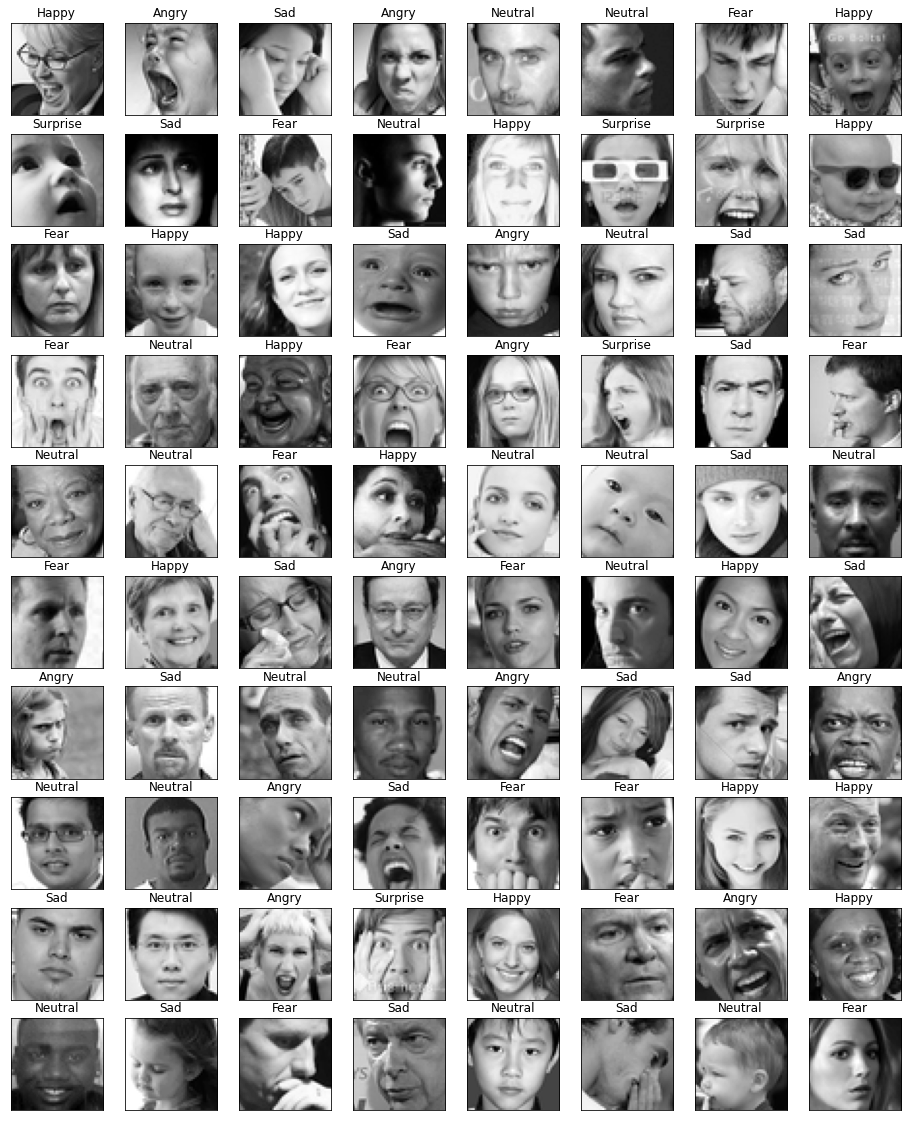

In [4]:
fig = plt.figure(figsize=(16,20))


for i in range(880,960):
    img, emotion = row2image(data.iloc[i])
    plt.subplot(10, 8, i % 80 + 1)
    plt.title(emotion, size=12)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());


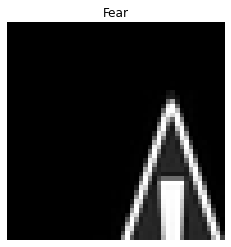

In [5]:
img, emotion = row2image(data.iloc[59])
plt.title(emotion, size=12)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off');
# remove_it?

# Data labels / The train, validation and test set

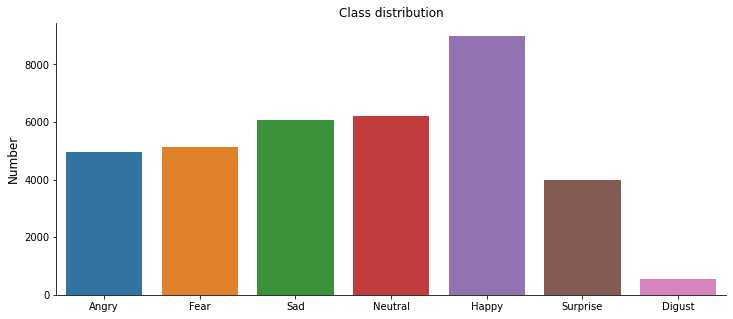

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts



plt.figure(figsize=(12,5))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('', fontsize=12)
sns.despine()
plt.show()

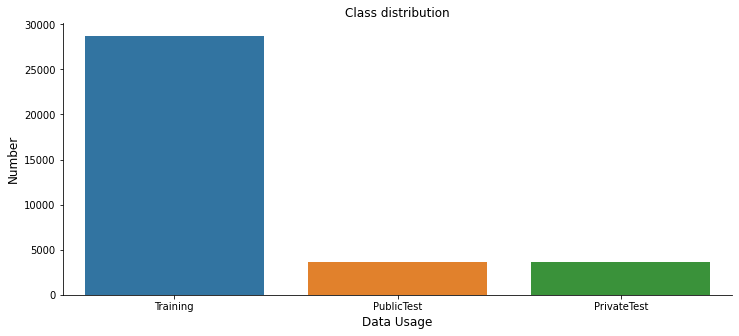

In [7]:
usage_counts = data['Usage'].value_counts(sort=False).reset_index()
usage_counts.columns = ['usage', 'number']

plt.figure(figsize=(12,5))
sns.barplot(x=usage_counts.usage, y=usage_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Data Usage', fontsize=12)
sns.despine()
plt.show()

#

In [8]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 

In [9]:
# define X_train, val, test

X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [10]:
# Define y_train,  val, test
y_train =  train_set.emotion
y_val = val_set.emotion
y_test = test_set.emotion


In [11]:
(X_train.shape,np.min(X_train), np.max(X_train))


((28709, 48, 48, 1), 0.0, 255.0)

# Data preprocessing

In [12]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

In [13]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

y_train_cat.shape

(28709, 7)

# Model architeture

In [14]:
model = Sequential()

model.add(Conv2D(32, (5, 5), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1), 
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(7, activation='softmax'))


2022-03-02 22:58:41.899224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:58:42.248570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:58:42.250755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:58:42.256849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

In [16]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [17]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    epochs=50,  # Use early stop in practice
                    validation_data=(X_val,y_val_cat),
                    use_multiprocessing = True,
                    callbacks=[es],
                    batch_size=32, 
                    verbose=1)

Epoch 1/50


2022-03-02 22:58:50.301904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-03-02 22:58:51.473464: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


898/898 [==============================] - 50s 51ms/step - loss: 1.5967 - accuracy: 0.3752 - val_loss: 1.4189 - val_accuracy: 0.4709
Epoch 2/50
898/898 [==============================] - 101s 113ms/step - loss: 1.3578 - accuracy: 0.4857 - val_loss: 1.2838 - val_accuracy: 0.5079
Epoch 3/50
898/898 [==============================] - 119s 133ms/step - loss: 1.2439 - accuracy: 0.5303 - val_loss: 1.2563 - val_accuracy: 0.5252
Epoch 4/50
898/898 [==============================] - 117s 130ms/step - loss: 1.1665 - accuracy: 0.5611 - val_loss: 1.2171 - val_accuracy: 0.5378
Epoch 5/50
898/898 [==============================] - 119s 132ms/step - loss: 1.1057 - accuracy: 0.5866 - val_loss: 1.1949 - val_accuracy: 0.5511
Epoch 6/50
898/898 [==============================] - 120s 133ms/step - loss: 1.0507 - accuracy: 0.6066 - val_loss: 1.2236 - val_accuracy: 0.5528
Epoch 7/50
898/898 [==============================] - 121s 135ms/step - loss: 1.0077 - accuracy: 0.6242 - val_loss: 1.2113 - val_accuracy

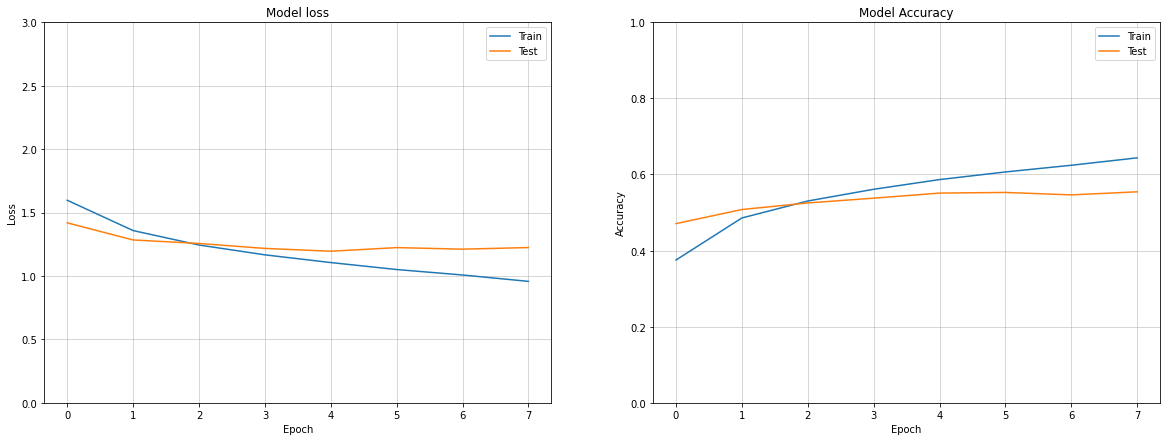

In [18]:
plot_loss_accuracy(history)

to be continued...

# Playing with images

In [19]:
# im
im = np.array(Image.open('../raw_data/385.jpg').convert('L'))

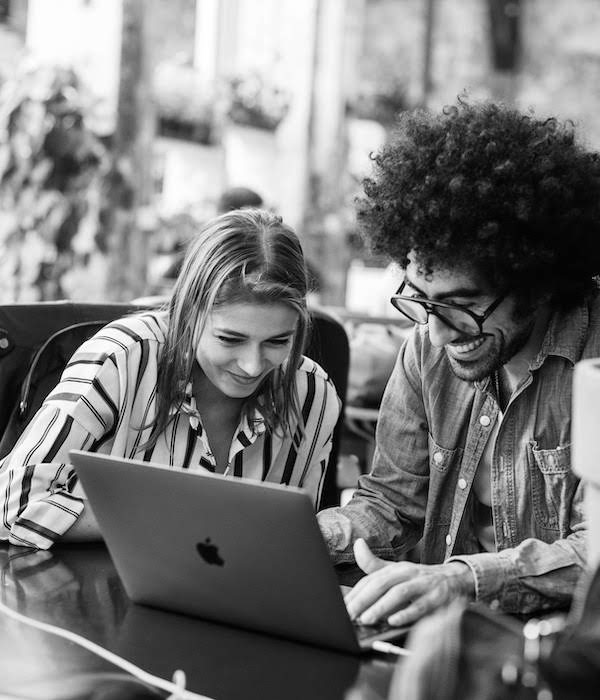

In [20]:
url ='https://dwj199mwkel52.cloudfront.net/assets/core/home/students_working-e4d394641e3b36353cec1643f67cb09d1dc2fe776b717b739106a2a6a603c3cd.jpg'
im = Image.open(urlopen(url)).convert('L')
im

In [21]:
im = np.array(im)
im.shape

(700, 600)